In [2]:
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier as NN

import math
import matplotlib as mpl
from functools import partial

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.gaussian_process import GaussianProcessClassifier as GPC
from sklearn.gaussian_process.kernels import RBF
from tqdm import tqdm
from scipy.sparse import csr_matrix, csgraph

from dijsktra_algorithm import Graph, dijsktra_toall
from density_estimator import DensityEstimator


In [6]:
# https://www.python-course.eu/neural_network_mnist.php
image_size = 28 # width and length
no_of_different_labels = 10 #  i.e. 0, 1, 2, 3, ..., 9
image_pixels = image_size * image_size
data_path = "../../FaceLift/utils/mnist_data/mnist_train.csv"
# train_data = np.loadtxt(data_path, delimiter=",")
# fac = 0.99 / 255
# train_imgs = np.asfarray(train_data[:, 1:]) * fac + 0.01
# train_ilabels = np.asfarray(train_data[:, :1]).ravel()

train_data = pd.read_csv(data_path, 
                        delimiter=",", header=None)
train_imgs = train_data.iloc[:, 1:]/255
train_labels = np.asarray(train_data.iloc[:, :1][0])


In [25]:
indices1 = set(np.where(train_labels == 1)[0][:1000])
indices9 = set(np.where(train_labels == 9)[0][:1000])
indices7 = set(np.where(train_labels == 7)[0][:1000])
indices4 = set(np.where(train_labels == 4)[0][:1000])
indices8 = set(np.where(train_labels == 8)[0][:1000])
indices0 = set(np.where(train_labels == 0)[0][:1000])
indices2 = set(np.where(train_labels == 2)[0][:1000])

digit_indices = [indices1, indices9, indices7, indices4, indices8, indices0, indices2]
indices = []
for digit_index in digit_indices:
    indices = set(indices).union(digit_index)

# indices = np.array(list(indices1.union(indices9.union(indices7.union(indices4.union(indices8.union()))))))

X = train_imgs.iloc[list(indices), :]
y = train_labels[list(indices)]


In [33]:
def inv_log(x):
    return -np.log(x)

def get_edges(kernel):
    edges = []

    n_samples = kernel.shape[0]
    for i in range(n_samples):
        for j in range(i):
            weight = kernel[i, j]
            if weight != 0 :
                edges.append([i, j, weight])
    return edges


def get_weights(X, 
                density_scorer, 
                # mode,
                weight_func = inv_log):
    epsilon = 1
    n_samples, _ = X.shape
    k = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        v0 = X[i, :].reshape(-1, 1)
        for j in range(i):
            v1 = X[j, :].reshape(-1, 1)
            dist = np.linalg.norm(v0 - v1)
            if dist <= epsilon:
                midpoint = (v0 + v1)/2
                density = density_scorer(midpoint.reshape(1, -1))
                # if mode == 1:
                k[i, j] = weight_func(np.exp(density)) * dist
                # else:
                #     k[i, j] = weight_func(sigmoid(density)) * dist
            # else:
            #     k[i, j] = 0
            # k[j, i] = k[i, j]
    return k

def calculate_weighted_distance(v0, v1, penalty_term = 2):
    diff = v0-v1
    reweight_vector = np.where(diff>=0, 1, -penalty_term)
    weighted_diff = np.linalg.norm(diff*reweight_vector)
    return weighted_diff

def get_weights_kNN(
    X, 
    n_neighbours = 20,
    alpha=0.10,
    weight_func = inv_log
    ):
    n_samples, n_ftrs = X.shape
    
    k = np.zeros((n_samples, n_samples))
    W = k
    for i in range(n_samples):
        v0 = X.iloc[i].values.reshape(-1, 1)
        for j in range(n_samples):
            v1 = X.iloc[j].values.reshape(-1, 1)
            # modify the distance function so that removing pixels incurring larger cost.
            dist = calculate_weighted_distance(v1, v0, penalty_term=1.1)
            # dist = np.linalg.norm(v0 - v1)
            k[i, j] = dist
            if dist != 0:
                W[i,j] = weight_func(dist)
        t = np.argsort(k[i, :])[(n_neighbours+1):]
        mask = np.ix_(t)
        k[i, mask] = 0
        W[i, mask] = 0
    # 
        
#     for i in range(n_samples):
#         v0 = X[i, :].reshape(-1, 1)
#         for j in range(n_samples):
#             v1 = X[j, :].reshape(-1, 1)
#             if k[i, j] != 0:
#                 current_value = k[i, j]
# #                 k[i, j] = current_value**alpha
#                 k[i, j] = weight_func(current_value)
    return W

def get_weights_e(X, 
                 epsilon = 0.75,
                 alpha=0.10,
                 weight_func = inv_log):
    n_samples, n_ftrs = X.shape
    k = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        v0 = X[i, :].reshape(-1, 1)
        for j in range(i):
            v1 = X[j, :].reshape(-1, 1)
            dist = np.linalg.norm(v0 - v1)
            if dist <= epsilon:
                k[i, j] = weight_func(current_value)
                k[j, i] = k[i, j]
    return k

In [27]:
clf = NN(max_iter=5000).fit(X, y)

In [28]:
predictions = clf.predict_proba(X)

In [ ]:
# bandwidths = 10 ** np.linspace(-2, 0, 10)
# grid = GridSearchCV(
#     KernelDensity(kernel='gaussian'),
#     {'bandwidth': bandwidth},
# )

# grid.fit(X)
# kde = grid.best_estimator_

# define the kernel density function after grid search
# bandwidth = 10 ** (-2 + 2/9*5)
# kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
# kde.fit(X)
# print(kde.get_params())


In [34]:
def construct_graph(weight_matrix):
    graph = csr_matrix(weight_matrix)
    return graph

def find_shortest_path(graph, start_point_idx):
    dist_matrix, predecessors = csgraph.dijkstra(
        csgraph=graph, directed=True, indices=start_point_idx, return_predecessors=True
    )
    return dist_matrix, predecessors

def reconstruct_shortest_path(predecessors, start_point_idx, end_point_idx):
    """Get all the nodes along the path between the start point and the end point. 

    Args:
        predecessors (matrix of shape (1, n_nodes)): contain the previous node in the path.
        start_point_idx (int): the index of the start data point
        end_point_idx (int): the index of the end data point

    Returns:
        node_path (list): [start_point_idx, intermedium points index, end_point_idx]
    """
    if predecessors[end_point_idx] == start_point_idx:
        node_path = [end_point_idx]
    else:
        node_path = []
    intermedium_idx = end_point_idx
    while (predecessors[intermedium_idx] != start_point_idx):
        node_path.append(intermedium_idx)
        intermedium_idx = predecessors[intermedium_idx]
    if intermedium_idx != node_path[-1]:
        node_path.append(intermedium_idx)
    node_path.append(start_point_idx)
    
    return node_path[::-1]
 
def build_symmetric_matrix(kernel):
    for i in range(kernel.shape[0]):
        for j in range(i):
            kernel[j, i] = kernel[i,j]
    return kernel

def build_asymmetric_matrix(kernel, X, weight_func):
    n_samples = kernel.shape[0]
    for i in range(n_samples):
        for j in range(n_samples):
            if kernel[i,j] != 0:
                v0 = X.iloc[i].values.reshape(-1, 1)
                v1 = X.iloc[j].values.reshape(-1, 1)
                dist = calculate_weighted_distance(v0, v1, penalty_term=1.1)
                kernel[j, i] = weight_func(dist)
    return kernel

In [35]:
n_neighbours = 20
n_samples, n_features = X.shape

def get_volume_of_sphere(d):
    return math.pi**(d/2)/math.gamma(d/2 + 1)

volume_sphere = get_volume_of_sphere(1)
r = (n_neighbours / (n_samples * volume_sphere))

# Construct the global weighted graph.
# Kernel is asymmetric if using KNN to get weight, and OG only keeps the bottom left half of the matrix
weight_func=lambda x: -x*np.log(r/x)  # x**alpha
kernel = get_weights_kNN(
            X,
            n_neighbours=int(n_neighbours),
            weight_func=weight_func
        )

# sym_kernel = build_symmetric_matrix(kernel)
asym_kernel = build_asymmetric_matrix(kernel, X, weight_func)

In [ ]:
graph = Graph()
edges = get_edges(kernel)
for edge in tqdm(edges):
    graph.add_edge(*edge) 

In [36]:
def get_minimum_dist(dist_matrix):
    """get the shortest distance and its data index
    Args:
        dist_matrix (array): shape: 1 x n_nodes

    Returns:
        min_dist: minimum distance in the distance matrix
        min_dist_idx: index of the data point with the shortest dist
    """
    min_dist = np.min(np.ma.masked_where(dist_matrix==0, dist_matrix, copy=False)) 
    min_dist_idx = np.argmin(np.ma.masked_where(dist_matrix==0, dist_matrix, copy=False))
    return min_dist, min_dist_idx

def get_closest_cf_point(dist_matrix, predictions, y, target_class, class_labels, num_paths = 1, pred_threshold=0.55):
    assert num_paths > 0 and isinstance(num_paths, int), "only positive integers"
    end_point_idx = []
    path_count = 0
    for idx in np.argsort(np.ma.masked_where(dist_matrix==0, dist_matrix)):
        if (y[idx] == target_class and
        predictions[idx, class_labels.index(target_class)] >= pred_threshold): 
            end_point_idx.append(idx)
            if path_count >= num_paths-1:
                break
            else:
                path_count += 1
    return end_point_idx

def get_user_agency(sp_graph, start_point_idx, alternative_classes, predictions, y, class_labels, pred_threshold=0.55):
    dist_matrix, predecessors = find_shortest_path(sp_graph, start_point_idx)
    alt_class_dict = {}
    for alt_class in alternative_classes:
        alt_end_idx = get_closest_cf_point(dist_matrix, predictions, y, alt_class, class_labels, pred_threshold = pred_threshold)
        alt_end_dist = dist_matrix[alt_end_idx[0]]
        alt_class_dict[alt_class] = {alt_end_idx[0]: alt_end_dist}
    return alt_class_dict

In [ ]:
def get_all_paths_agency():
    pass

In [48]:
np.where(y==1)

(array([   2,    5,    6,    8,   16,   17,   27,   42,   47,   50,   52,
          55,   56,   72,   74,   76,   77,   81,   82,   93,   96,   99,
         110,  128,  130,  134,  147,  148,  150,  152,  155,  164,  170,
         180,  182,  194,  195,  199,  207,  221,  222,  226,  246,  252,
         256,  257,  258,  265,  279,  289,  290,  291,  296,  297,  305,
         324,  328,  330,  333,  334,  342,  346,  350,  357,  361,  362,
         369,  370,  371,  389,  390,  391,  399,  400,  402,  415,  416,
         426,  431,  440,  444,  450,  462,  463,  471,  486,  489,  491,
         501,  507,  517,  518,  538,  546,  557,  565,  566,  569,  588,
         596,  606,  608,  609,  631,  632,  645,  655,  664,  665,  682,
         690,  694,  695,  706,  710,  717,  723,  724,  732,  737,  748,
         757,  764,  765,  772,  776,  779,  787,  788,  791,  792,  798,
         811,  813,  816,  823,  824,  834,  839,  855,  861,  867,  872,
         875,  881,  895,  901,  903, 

In [49]:
sp_graph = construct_graph(asym_kernel)
start_point_idx = 2
target_class = 9
class_labels = list(map(int, clf.classes_))
alternative_classes = list(set(class_labels) - set([target_class, y[start_point_idx]]))
res = {}
res[start_point_idx] = {}

dist_matrix, predecessors = find_shortest_path(sp_graph, start_point_idx=start_point_idx)

end_point_indices = get_closest_cf_point(dist_matrix, predictions, y, target_class, class_labels, num_paths=20)
print(end_point_indices)

for order, end_point_idx in enumerate(end_point_indices):
    shortest_path = reconstruct_shortest_path(predecessors, start_point_idx=start_point_idx, end_point_idx=end_point_idx)
    # print()
    for node_idx in shortest_path[:-1]:
        alt_classes = list(set(class_labels) - set([target_class, y[node_idx]]))
        alt_class_dict = get_user_agency(sp_graph, node_idx, alt_classes, predictions, y, class_labels)
        # print("node index: ", node_idx)
        # print(alt_class_dict)

        res[start_point_idx][order] = shortest_path
print(res)

[2503, 5133, 466, 5229, 2563, 2123, 1051, 1039, 422, 1137, 5891, 3898, 5207, 366, 2504, 2391, 385, 2581, 626, 3740]
{2: {0: [2, 486, 2503], 1: [2, 16, 5815, 5133], 2: [2, 4103, 1077, 466], 3: [2, 5798, 748, 5229], 4: [2, 5292, 1726, 2563], 5: [2, 2928, 5165, 2123], 6: [2, 16, 5815, 5133, 1051], 7: [2, 416, 2952, 1112, 1039], 8: [2, 16, 5815, 5133, 422], 9: [2, 416, 2952, 1112, 1137], 10: [2, 16, 5815, 5133, 5891], 11: [2, 2946, 2898, 3898], 12: [2, 416, 1093, 2460, 5207], 13: [2, 16, 5815, 5133, 366], 14: [2, 16, 5815, 2458, 2504], 15: [2, 5292, 1462, 5073, 2636, 2391], 16: [2, 16, 1145, 5988, 385], 17: [2, 16, 5815, 2458, 2581], 18: [2, 5292, 1462, 5100, 3977, 626], 19: [2, 4103, 1077, 466, 3740]}}


In [52]:
#4
shortest_path = reconstruct_shortest_path(predecessors, start_point_idx=start_point_idx, end_point_idx=2581)
# print()
for node_idx in shortest_path[:-1]:
    alt_classes = list(set(class_labels) - set([target_class, y[node_idx]]))
    alt_class_dict = get_user_agency(sp_graph, node_idx, alt_classes, predictions, y, class_labels)
    print("node index: ", node_idx)
    print(alt_class_dict)



node index:  2
{0: {1088: 153.36609466742624}, 2: {6034: 68.99109024824892}, 4: {44: 61.24142130574533}, 7: {4364: 57.38998932973475}, 8: {6772: 73.14110766884947}}
node index:  16
{0: {6466: 144.2724164738749}, 2: {2226: 67.54503585100791}, 4: {44: 48.741752057600024}, 7: {1850: 49.25593903366071}, 8: {6704: 70.3800658408136}}
node index:  5815
{0: {1999: 165.36534962967193}, 2: {2847: 48.85662400522374}, 4: {3000: 44.17538103213447}, 7: {5165: 37.50616223025132}, 8: {621: 53.71259219467313}}
node index:  2458
{0: {5141: 141.71812567002414}, 1: {748: 44.71436341584624}, 2: {2357: 89.40060904563364}, 7: {5164: 44.94051314718127}, 8: {6684: 54.54935580826052}}


In [51]:
#7
shortest_path = reconstruct_shortest_path(predecessors, start_point_idx=start_point_idx, end_point_idx=626)
# print()
for node_idx in shortest_path[:-1]:
    alt_classes = list(set(class_labels) - set([target_class, y[node_idx]]))
    alt_class_dict = get_user_agency(sp_graph, node_idx, alt_classes, predictions, y, class_labels)
    print("node index: ", node_idx)
    print(alt_class_dict)



node index:  2
{0: {1088: 153.36609466742624}, 2: {6034: 68.99109024824892}, 4: {44: 61.24142130574533}, 7: {4364: 57.38998932973475}, 8: {6772: 73.14110766884947}}
node index:  5292
{0: {1088: 132.58142118994013}, 2: {6034: 82.58089451878175}, 4: {6826: 72.3977710757}, 7: {1324: 57.39978647188613}, 8: {6916: 65.68918189994933}}
node index:  1462
{0: {1088: 131.07246211890978}, 2: {427: 64.77328273728226}, 4: {5177: 60.95214041738748}, 7: {1324: 35.36254814192508}, 8: {4019: 62.882617695664464}}
node index:  5100
{0: {3712: 138.26143705101362}, 2: {427: 58.99158899293038}, 4: {6929: 43.19788111596109}, 7: {1324: 33.16903726935579}, 8: {4019: 63.32727573402195}}
node index:  3977
{0: {1088: 136.7990841313817}, 1: {2636: 30.1419216967462}, 2: {6326: 51.1152642002417}, 4: {2386: 74.67152111632639}, 8: {2857: 73.26003875555521}}


In [55]:
(144.2724164738749 + 67.54503585100791 + 48.741752057600024 + 49.25593903366071 + 70.3800658408136 + 165.36534962967193 + 48.85662400522374 + 44.17538103213447 + 37.50616223025132 + 53.71259219467313 + 141.71812567002414 + 44.71436341584624 + 89.40060904563364 + 44.94051314718127 + 54.54935580826052)/15

73.67561902905716

In [56]:
(132.58142118994013 + 82.58089451878175 + 72.3977710757 + 57.39978647188613 + 65.68918189994933 + 131.07246211890978 + 64.77328273728226 + 60.95214041738748 + 35.36254814192508 + 62.882617695664464 + 138.26143705101362 + 58.99158899293038 + 43.19788111596109 + 33.16903726935579 + 63.32727573402195 + 136.7990841313817 + 30.1419216967462 + 51.1152642002417 + 74.67152111632639 + 73.26003875555521)/20

73.43135781654802

In [ ]:
res = {}
for test_index in range(0, 1):  # index = 1 or index = 2
    test_index = 0
    res[test_index] = {}
    # number of paths
    for idx, alpha in enumerate([1]):  # np.linspace(0.01, 3, 9)
        dist, paths = dijsktra_toall(graph, test_index)
        for item, val in paths.items():
            if (y[item] == 9        # y == target class not opposite to factual class
                and predictions[item, list(clf.classes_).index(y[item])] >= 0.55):
                res[test_index][idx] = val


In [ ]:
# print
print(res)
# {0: {0: [0, 2054, 2665, 2745, 423, 3497, 2655, 1333]}, 
# 1: {0: [1, 500, 2065, 88, 862, 3575, 2105, 224, 796, 2655, 1333]}}

In [46]:
def plot_digits(path, _id):
    n_digits = len(path)
    ncols=min(10, n_digits)
    nrows = math.ceil(n_digits / ncols)
    _, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 4*nrows))
    axes = axes.ravel()
    for idx, img_idx in enumerate(path):
        ax = axes[idx]
        image = np.array(X.iloc[img_idx, :])
        label = y[img_idx]
        ax.set_axis_off()
        ax.imshow(image.reshape(28, 28), cmap=plt.cm.gray_r, interpolation="nearest")
        ax.set_title(f"id:{_id}, t: {label}")
    plt.savefig(f'example_{_id}_log.pdf', dpi=300)

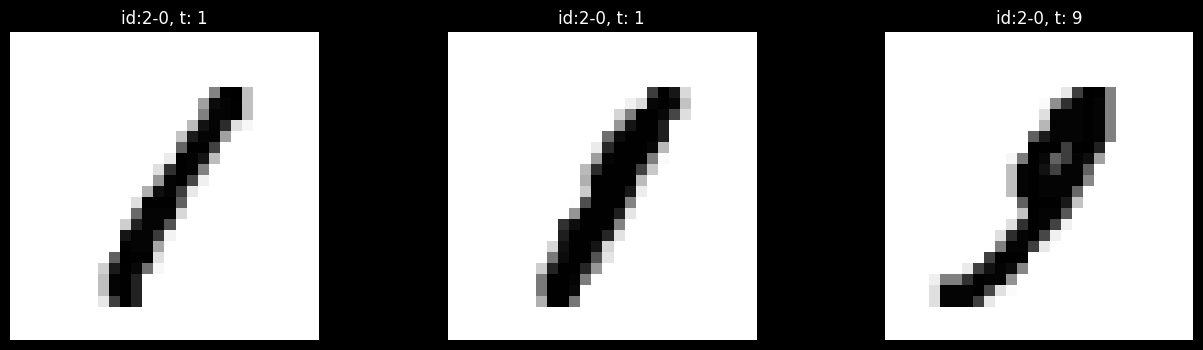

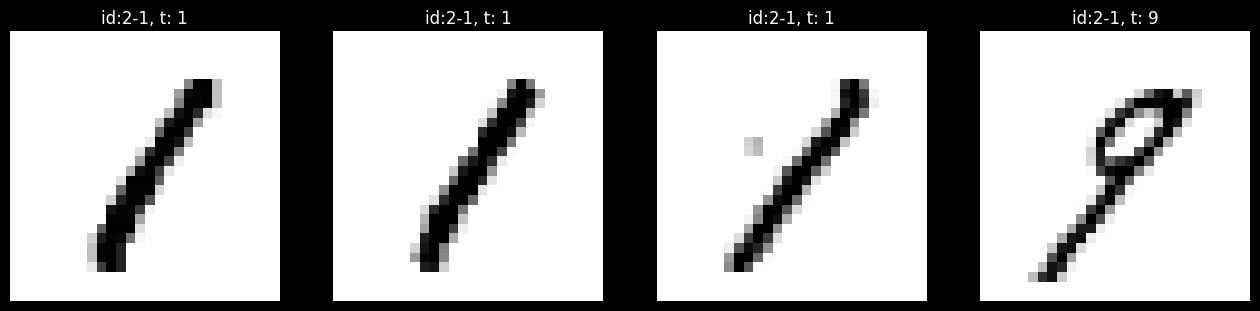

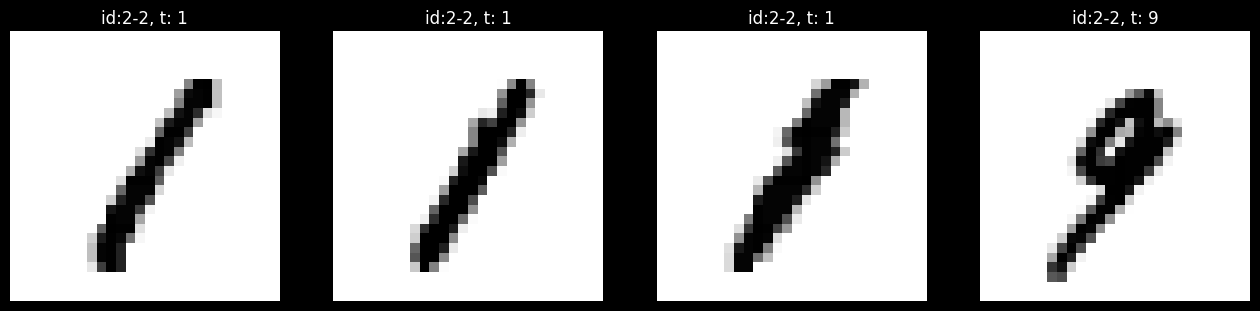

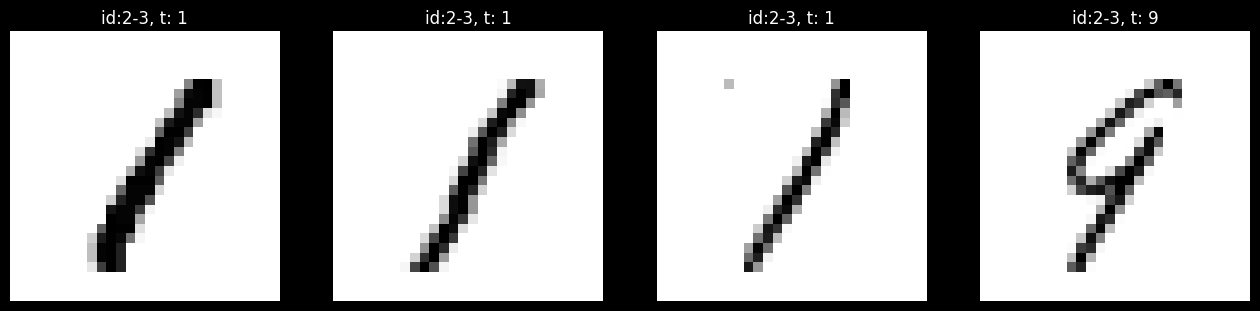

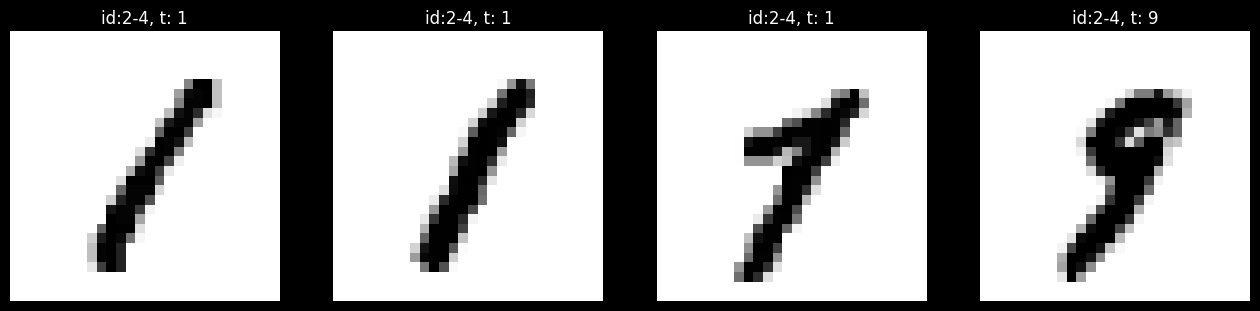

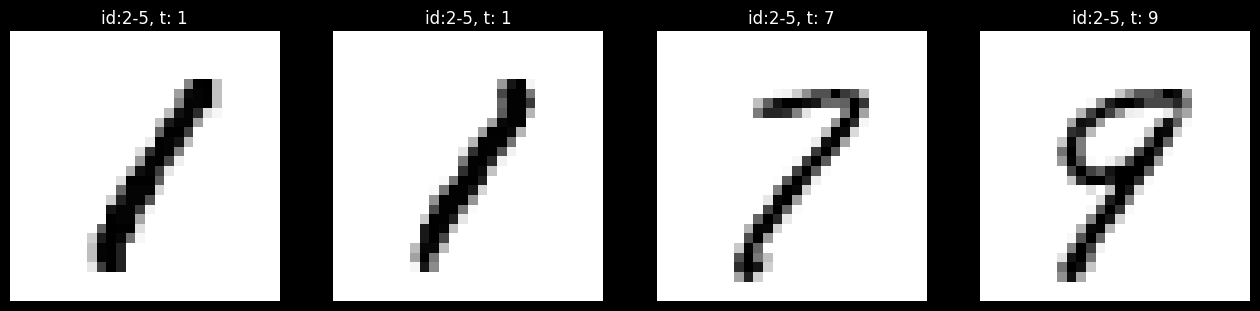

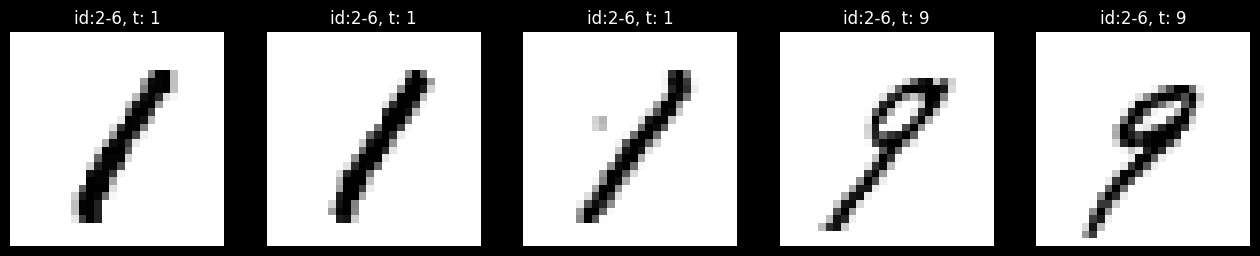

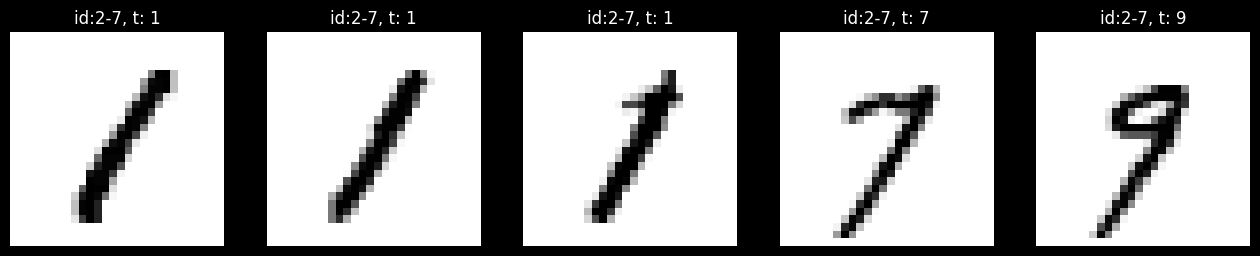

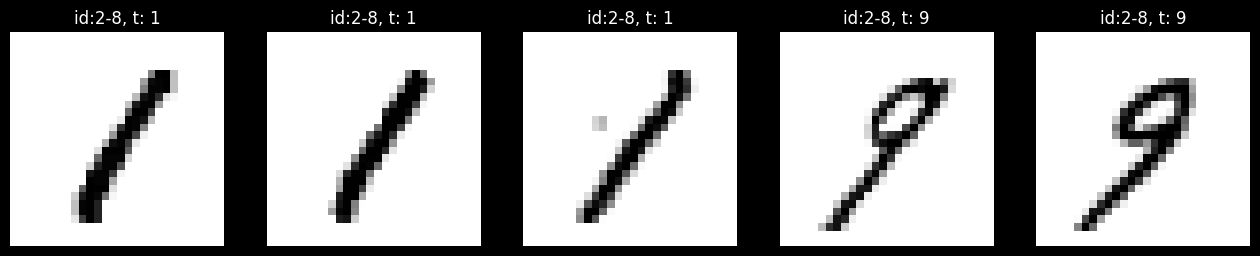

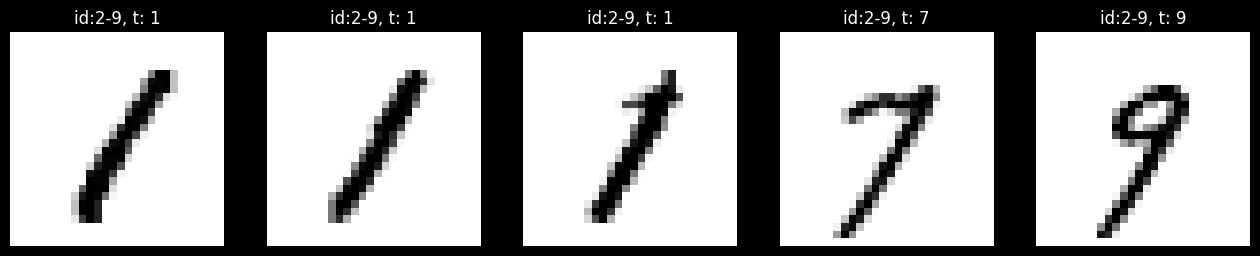

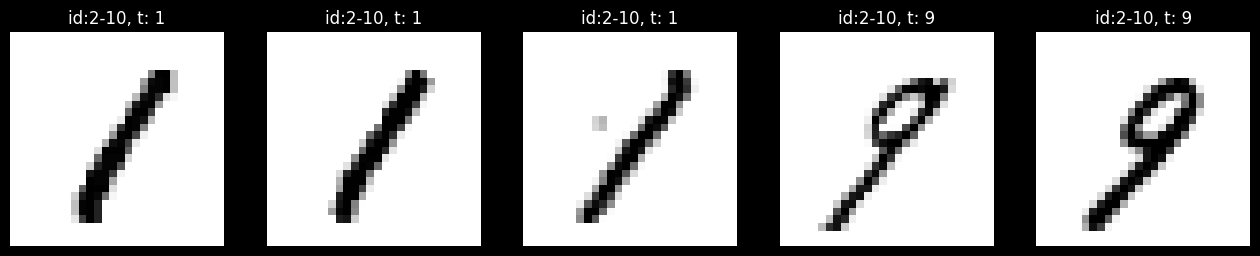

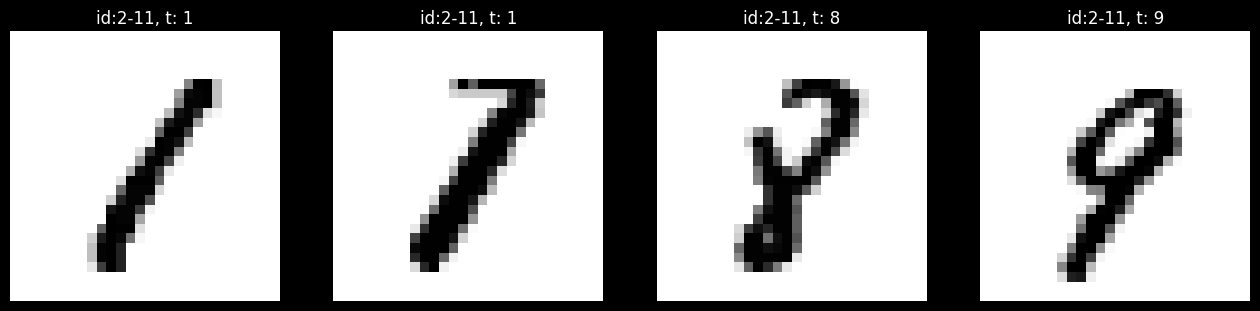

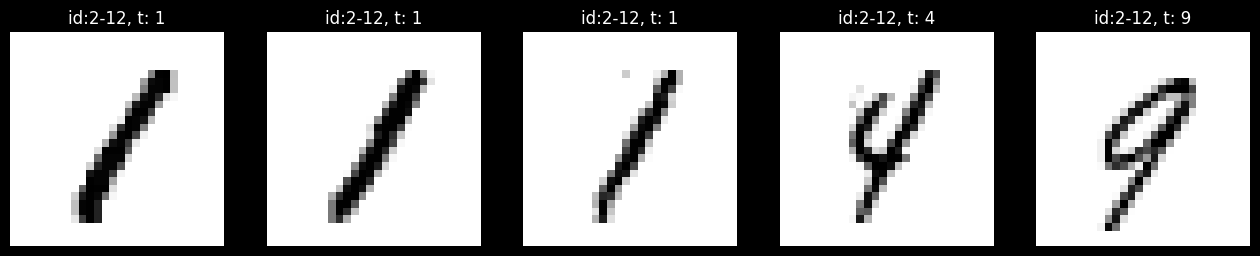

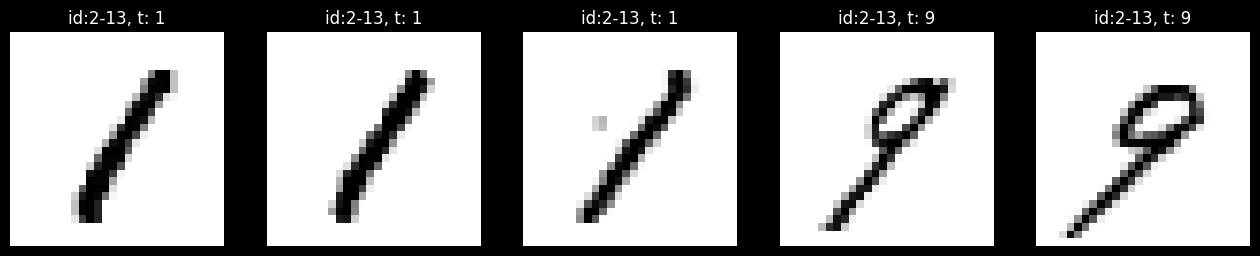

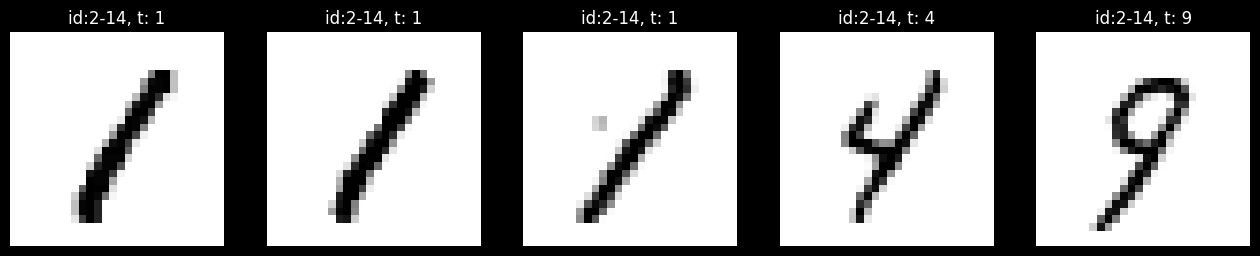

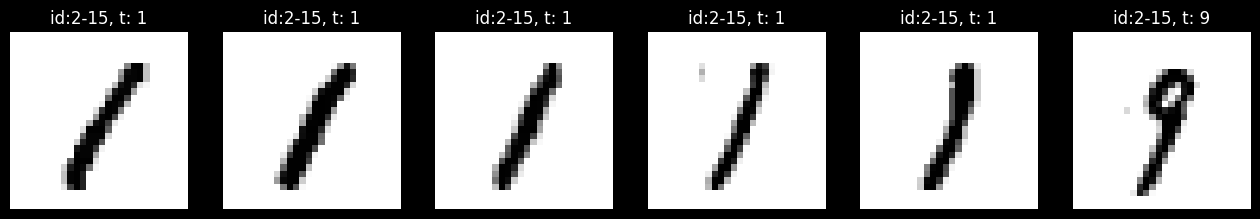

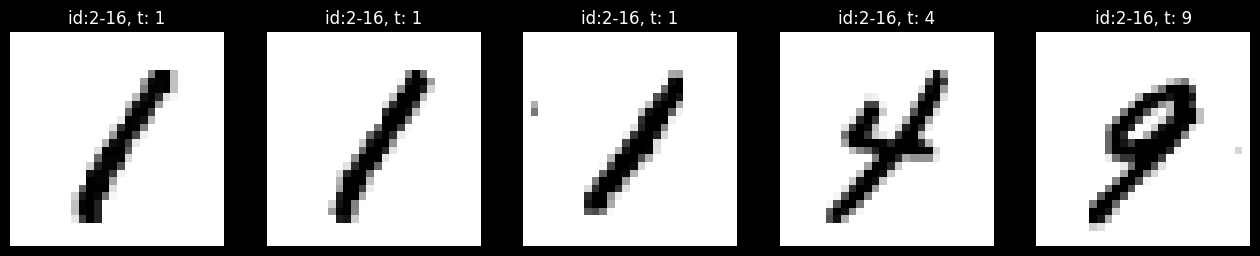

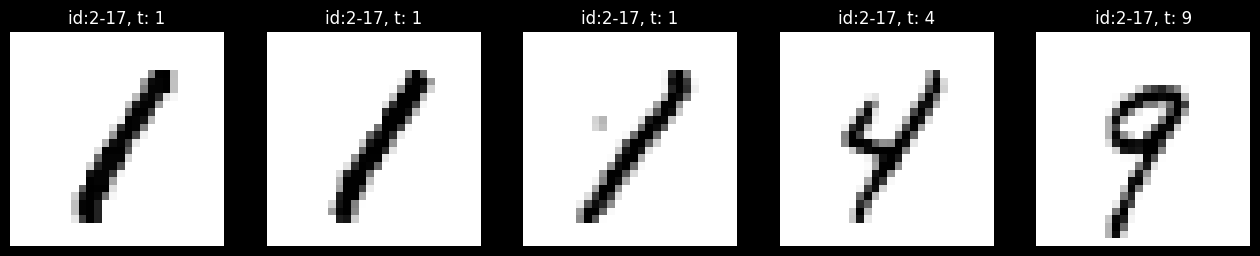

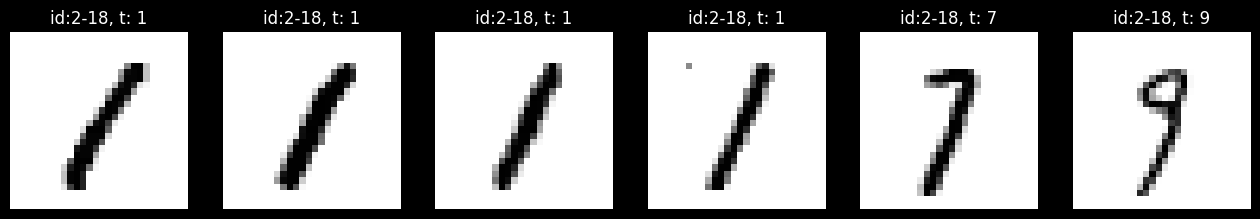

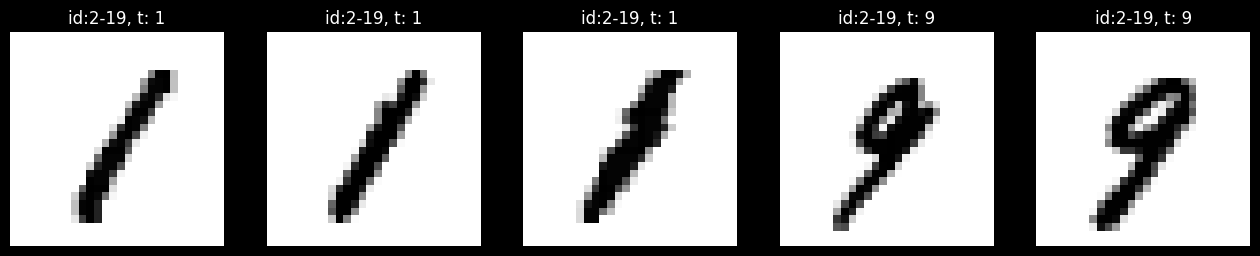

In [50]:
for k in res.keys():
    for k2 in res[k].keys():
        plot_digits(res[k][k2], '-'.join(map(str, [k, k2])))